In [1]:
import nibabel as nib
from nilearn.image import resample_to_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

subs = [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27]
stim_intensities = [55, 47, 56, 63, 60, 53, 54, 55, 60, 44, 46, 58, 47, 55, 50, 53, 50, 48, 50, 50]

subs = [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 25, 26, 27]
stim_intensities = [55, 47, 56, 63, 60, 53, 54, 55, 60, 44, 46, 58, 47, 55, 50, 53, 48, 50, 50]
stim_dIdt = [round((a / 60) * 87 *1e6) for a in stim_intensities]
masterpath = "/d/DATC/datc/MD_TMS_EEG/SIMNIBS_output/"

In [12]:
print(stim_dIdt)

[79750000, 68150000, 81200000, 91350000, 87000000, 76850000, 78300000, 79750000, 87000000, 63800000, 66700000, 84100000, 68150000, 79750000, 72500000, 76850000, 69600000, 72500000, 72500000]


In [2]:
# Read csv file containing coil location information
metadatapath = '/d/DATC/datc/MD_TMS_EEG/analysis/EEG_TMS_meta - Summary.csv' 
df = pd.read_csv(metadatapath)
hemisphere_values = df['Hemisphere stimulated'].values
print(hemisphere_values)


['Left' 'Left' 'Right' 'Right' 'Left' 'Right' 'Left' 'Right' 'Right'
 'Right' 'Left' 'Left' 'Left' 'Right' 'Right' 'Left' 'Left' 'Right' nan
 nan 'Right' 'Right' 'Right' 'Left' 'Right' 'Left' 'Left' nan nan]


In [65]:
# Function to load nifty
def load_nii_file(fpath, T1):
    nii_img = nib.load(fpath)
    if nii_img.shape[0] != 320:
        nii_img = resample_to_img(fpath, T1, interpolation='nearest')
    data = nii_img.get_fdata()
    
    return data

# Function to compute average from mask
def calculate_average_over_mask(whole_brain, mask):
    masked_data = whole_brain[mask > 0]
    #print(masked_data.shape)
    average_value = masked_data.max() 
    #########print(average_value)
    return average_value

In [ ]:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [93]:
data = {}
meanarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
allvalsarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
for idx in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
    sub = subs[idx]
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_values[sub-1]

    subfoldpath = f"{masterpath}{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }

    data[sub_id] = {roi_name: load_nii_file(path, file_paths['T1'])
                    for roi_name, path in file_paths.items()}
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    
    for roi_name, path in file_paths.items():
        roi_data = load_nii_file(path, f"{subfoldpath}/T1.nii")
        allvalsarray[roi_name].extend(metric_data[roi_data>0].flatten())
        mean_value = calculate_average_over_mask(metric_data, roi_data)
        meanarray[roi_name].append(mean_value)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


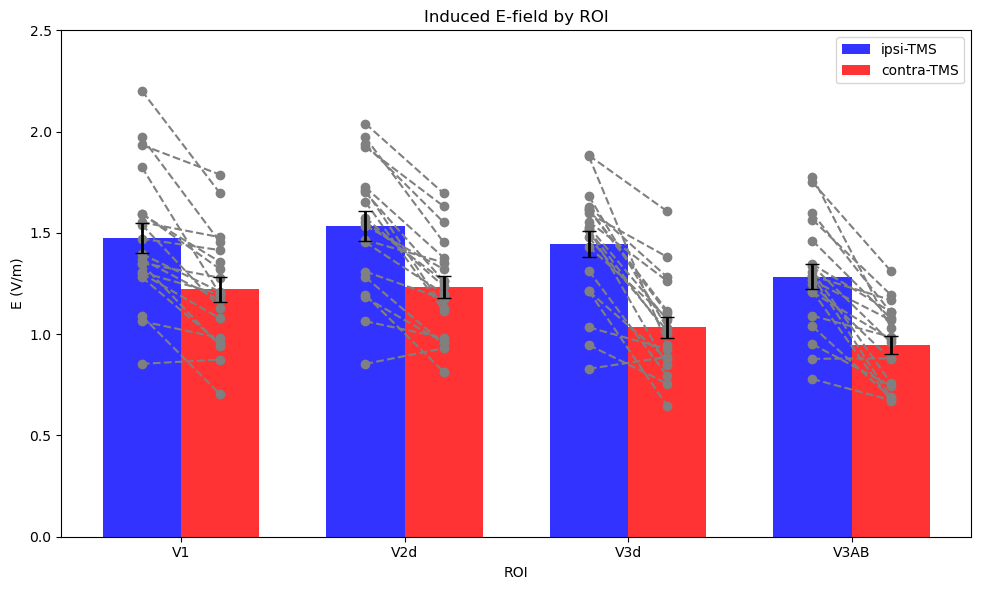

In [78]:
means = {roi: np.mean(values) for roi, values in meanarray.items()}
std_errors = {roi: np.std(values) / np.sqrt(len(values)) for roi, values in meanarray.items()}
roi_list = ['V1', 'V2d', 'V3d', 'V3AB']

fig, ax = plt.subplots(figsize=(10, 6))

n_groups = len(means) // 2
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, roi in enumerate(roi_list):
    lh_mean = meanarray[f'lh{roi}']
    rh_mean = meanarray[f'rh{roi}']
    lh_x = index[i] - bar_width/2
    rh_x = lh_x + bar_width
    ax.plot([lh_x + bar_width/2, rh_x + bar_width/2], [lh_mean, rh_mean], 'grey', linestyle='--', marker='o')


left_bars = ax.bar(index, [means[f'lh{roi}'] for roi in roi_list],
                   bar_width, alpha=opacity, color='b',
                   yerr=[std_errors[f'lh{roi}'] for roi in roi_list],
                   label='ipsi-TMS', error_kw={'elinewidth':2, 'capsize':5})

right_bars = ax.bar(index + bar_width, [means[f'rh{roi}'] for roi in roi_list],
                    bar_width, alpha=opacity, color='r',
                    yerr=[std_errors[f'rh{roi}'] for roi in roi_list],
                    label='contra-TMS', error_kw={'elinewidth':2, 'capsize':5})

ax.set_xlabel('ROI')
ax.set_ylabel('E (V/m)')
ax.set_title('Induced E-field by ROI')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(roi_list)
ax.legend()

# Adding a grid, setting the limit and making layout tight
#ax.yaxis.grid(True)
ax.set_ylim([0, max(means.values()) + max(std_errors.values()) * 3])  # Adjust the y-axis limit to show error bars
plt.tight_layout()
plt.ylim([0, 2.5])
# Show the plot
plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/efield_induced_max.eps', format = 'eps', dpi = 1200)
plt.show()

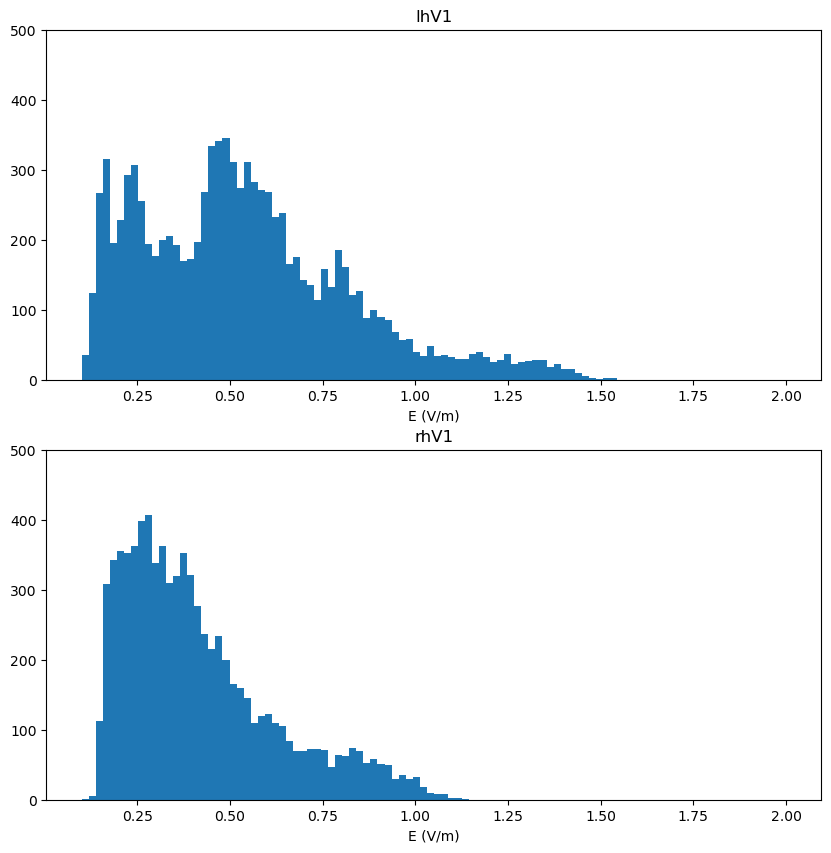

In [84]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
ax[0].hist(allvalsarray['lhV1'], bins = 100, range = (0.1, 2))
ax[1].hist(allvalsarray['rhV1'], bins = 100, range = (0.1, 2))
ax[0].set_title('lhV1')
ax[1].set_title('rhV1')
ax[0].set_ylim([0, 500])
ax[1].set_ylim([0, 500])
ax[0].set_xlabel('E (V/m)')
ax[1].set_xlabel('E (V/m)')
plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/hist_efield_V1_sub01.eps', format = 'eps', dpi = 1200)
plt.show()
#plt.xlim([0.1, 1])

In [91]:
print(np.median(allvalsarray['lhV1']), np.median(allvalsarray['rhV1']))

0.22523243725299835 0.21146932244300842


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


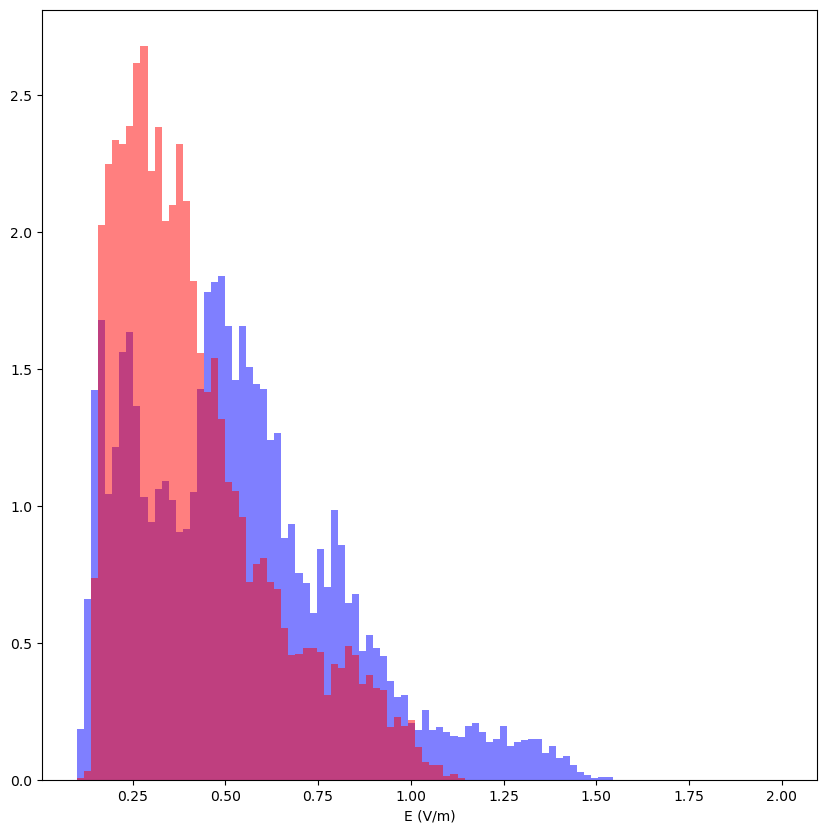

In [85]:
fig = plt.figure(figsize = (10, 10))
plt.hist(allvalsarray['lhV1'], bins = 100, range = (0.1, 2), density = True, color = 'blue', alpha = 0.5)
plt.hist(allvalsarray['rhV1'], bins = 100, range = (0.1, 2), density = True, color = 'red', alpha = 0.5)
plt.xlabel('E (V/m)')
plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/hist_efield_V1_something_sub01.eps', format = 'eps', dpi = 1200)
plt.show()

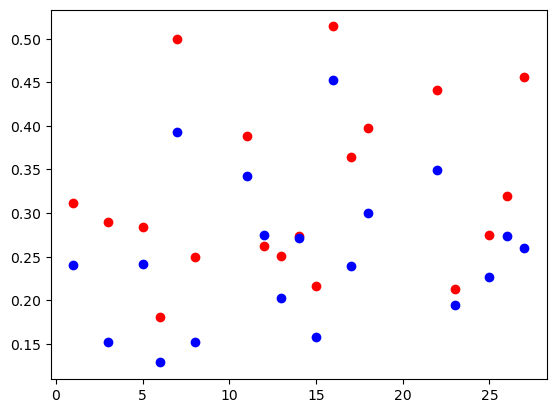

In [26]:
plt.figure()
plt.plot(subs, meanarray['lhV1'], 'ro')
plt.plot(subs, meanarray['rhV1'], 'bo')

In [92]:
sizearray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
Efieldarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
roi_list = ['T1', 'lhV1', 'rhV1', 'lhV2d', 'rhV2d', 'lhV3d', 'rhV3d', 'lhV3AB', 'rhV3AB']
for idx in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
    sub = subs[idx]
    sub_id = f"sub{sub:02d}"
    for roi_name in roi_list:
        sizearray[roi_name].append(np.sum(data[sub_id][roi_name]))
        Efieldarray[roi_name].append(meanarray[roi_name][idx])

KeyError: 'sub03'

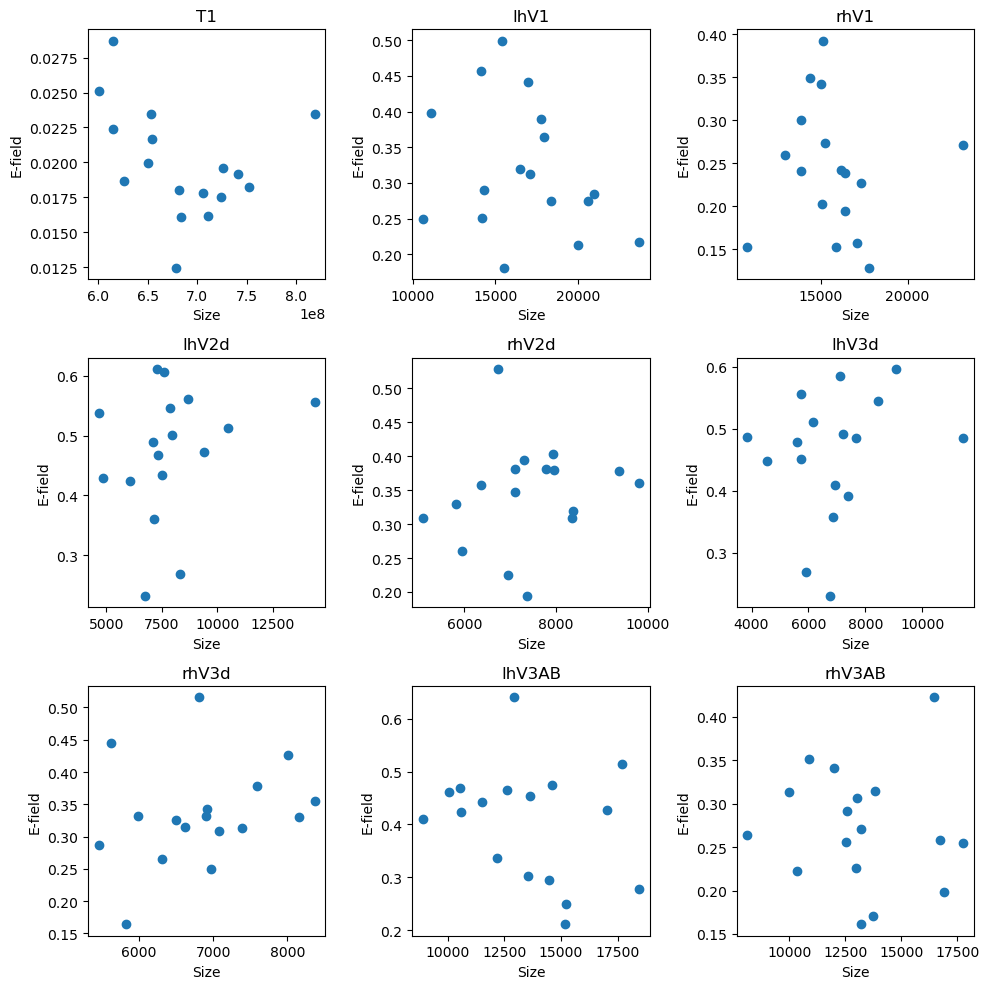

In [16]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))
axs = axs.flatten()
idx_plot = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]
for ax, roi_name in zip(axs, roi_list):
    #this_x = [sizearray[roi_name][i] for i in idx_plot]
    this_x = [stim_intensities]
    this_y = [Efieldarray[roi_name][i] for i in idx_plot]
    ax.scatter(this_x, this_y)
    ax.set_title(roi_name)
    ax.set_xlabel('Size')
    ax.set_ylabel('E-field')
plt.tight_layout()
plt.show()

In [38]:
master_df = pd.read_csv('/d/DATC/datc/MD_TMS_EEG/analysis/meta_analysis/master_df.csv')
master_df.head()

,subjID,day,tnum,rnum,istms,ispro,instimVF,bad_drift_correct,bad_calibration,breakfix,...,fsaccRadius,fsaccTheta,fsaccX_rotated,fsaccY_rotated,TarRadius_rotated,TarTheta_rotated,isaccRadius_rotated,isaccTheta_rotated,fsaccRadius_rotated,fsaccTheta_rotated
0,1,1,1,1,1,1,1,0,0,1,...,13.099912,-0.107134,17.727209,0.741290,17.808968,3.215190,19.426714,3.221673,17.742701,3.183385
1,1,1,2,1,1,1,1,0,0,0,...,14.875938,-0.240718,17.554281,-1.615880,17.808968,3.108540,17.628495,3.049801,17.628495,3.049801
2,1,1,3,1,1,1,0,0,0,0,...,14.187261,-3.113590,18.401291,-2.236062,17.808968,3.000846,18.536652,3.020669,18.536652,3.020669
3,1,1,4,1,1,1,0,0,0,0,...,14.959868,-3.065606,18.194527,-1.329463,17.808968,3.074234,18.243034,3.068653,18.243034,3.068653
4,1,1,5,1,1,1,1,0,0,0,...,11.498380,-0.059449,14.722413,1.320854,17.808968,3.208951,14.781546,3.231070,14.781546,3.231070


In [26]:
tempt

[12188,
 8924,
 10599,
 15201,
 14580,
 13627,
 18427,
 78550,
 11496,
 15175,
 10078,
 1113,
 17028,
 13557,
 12918,
 14462,
 12599,
 17664,
 10565]

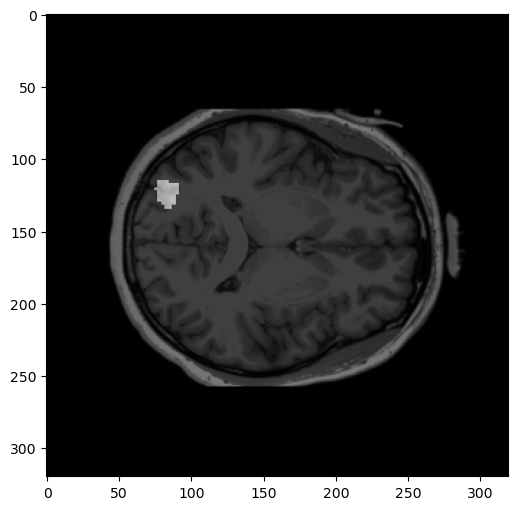

In [20]:
slcnum = 140
plt.figure(figsize=(10, 6))
plt.imshow(data['sub03']['T1'][:, slcnum, :], cmap='gray')
#plt.imshow(data['sub01']['lhV1'][:, slcnum, :], cmap = 'gray', alpha = 0.5)
plt.imshow(data['sub03']['lhV3AB'][:, slcnum, :], cmap = 'gray', alpha = 0.5)

plt.show()